# Fair tuning in COMPAS example

Protected attributes

In [2]:
# Columns to enforce statistical parity
protected_columns = ['race', 'age', 'sex']

## Data import and processing

In [3]:
import numpy as np 
import pandas as pd 

compas = pd.read_csv("data/compas/compas-scores-two-years-processed.csv")

# Print summary
print(compas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              5278 non-null   object
 1   age              5278 non-null   int64 
 2   race             5278 non-null   object
 3   priors_count     5278 non-null   int64 
 4   c_charge_degree  5278 non-null   object
 5   two_year_recid   5278 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 247.5+ KB
None


Summary statistics of binary attributes

In [ ]:
categorical_columns = compas.select_dtypes(include=['object']).columns
for col in categorical_columns:
    # Print the countes of each unique value
    print(f'Counts of unique values in {col}:')
    print(compas[col].value_counts())
    # Print the percentage of each unique value
    print(f'Percentages of unique values in {col}:')
    print(compas[col].value_counts(normalize=True))
    print()

Counts of unique values in sex:
sex
Male      4247
Female    1031
Name: count, dtype: int64
Percentages of unique values in sex:
sex
Male      0.804661
Female    0.195339
Name: proportion, dtype: float64

Counts of unique values in race:
race
African-American    3175
Caucasian           2103
Name: count, dtype: int64
Percentages of unique values in race:
race
African-American    0.601554
Caucasian           0.398446
Name: proportion, dtype: float64

Counts of unique values in c_charge_degree:
c_charge_degree
F    3440
M    1838
Name: count, dtype: int64
Percentages of unique values in c_charge_degree:
c_charge_degree
F    0.651762
M    0.348238
Name: proportion, dtype: float64



Pre-processing

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Recode binary variables 
df = compas.copy()
columns_to_encode = [
    'sex',
    'race',
    'c_charge_degree'
]

label_encoders = {}
for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Standardize continuous variables
scaler = StandardScaler()
df[['age', 'priors_count']] = scaler.fit_transform(df[['age', 'priors_count']])

In [6]:
for column, le in label_encoders.items():
    print(f"Mapping for {column}:")
    for class_num, class_label in enumerate(le.classes_):
        print(f"{class_num} -> {class_label}")

Mapping for sex:
0 -> Female
1 -> Male
Mapping for race:
0 -> African-American
1 -> Caucasian
Mapping for c_charge_degree:
0 -> F
1 -> M


In [ ]:
X = df.drop(columns=['two_year_recid'])
y = df['two_year_recid']

## Modelling

Training parameters

In [8]:
from torch import nn

n_features = X.shape[1]
n_epochs = 400
batch_size = 32
hidden_layers = [64, 64]
activation = nn.ELU()

#### Unconstrained model

Data preparation and training parameters

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# Create a DataLoader
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Training or loading model

In [10]:
# Dict to store models
models = {}
# Dict to store losses
losses = {}

In [11]:
import os 
from torch import optim
from Models import NeuralClassifier

# Create the model
model = "Unconstrained"
models[model] = NeuralClassifier(n_features, hidden_layers, activation)

# If model exists in models/linear/spd_model.pt, load it
model_path = f'models/COMPAS/unconstrained_model.pt'
losses_path = f'models/COMPAS/unconstrained_losses.npy'
if os.path.exists(model_path):
    print(f'Model exists, loading model from {model_path}')
    # Load model
    models[model].load_state_dict(torch.load(model_path))
    # Load losses
    losses[model] = np.load(losses_path, allow_pickle=True).item()
else:
    print('Training model from scratch')
    # Define the train loader, loss function, and the optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(models[model].parameters(), lr=0.001)

    # Training
    losses[model] = {'Total': []}
    for epoch in range(n_epochs):
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch, y_batch

            optimizer.zero_grad()
            y_pred = models[model](X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Print epoch training loss
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss/len(train_loader)}\r', end='')
        
        losses[model]['Total'].append(train_loss/len(train_loader))

    # Save the model
    if not os.path.exists('models/COMPAS'):
        os.makedirs('models/COMPAS')
    torch.save(models[model].state_dict(), model_path)
    # Save losses
    np.save(losses_path, np.array(losses[model]))

models[model] = models[model].eval()


Model exists, loading model from models/COMPAS/unconstrained_model.pt


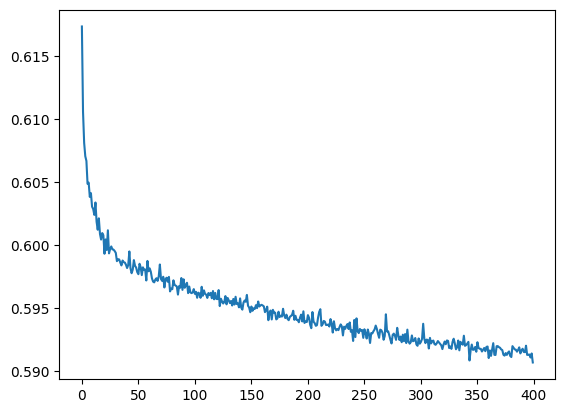

In [12]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(losses[model]['Total'])

### Fair tuning

Data preparation

In [13]:
# Convert the data to PyTorch tensors
X_tensor_with_grad = torch.tensor(X.values, dtype=torch.float32, requires_grad=True)
models['Unconstrained'].eval()
pred_train = models['Unconstrained'](X_tensor_with_grad).squeeze()
unconstrained_gradients = torch.autograd.grad(pred_train, X_tensor_with_grad, grad_outputs=torch.ones_like(pred_train), create_graph=True)[0].detach()

# Create a DataLoader
train_dataset = TensorDataset(X_tensor_with_grad, unconstrained_gradients, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Fairness parameters

In [14]:
n_epochs_tune = 50
# Columns to enforce statistical parity
sp_idx = [X.columns.get_loc(col) for col in protected_columns]
# Columns to enforce predictive parity
pp_idx = [i for i in range(X.shape[1]) if i not in sp_idx] 
# Tuned models
tuning_parameters = {
    'FT 10': {'sp': 10, 'pp': 10},
    #'FT 5': {'sp': 10, 'pp': 5},
    'FT 1': {'sp': 10, 'pp': 1},
    #'SPT 100': {'sp': 10, 'pp': 0},
    'SPT 10': {'sp': 10, 'pp': 0},
    #'SPT 5': {'sp': 5, 'pp': 0},
    #'FT Manhattan': {'sp': 5.8, 'pp': 6.1},
}

In [15]:
print(f'SP idx: {sp_idx}')
print(f'PP idx: {pp_idx}')

SP idx: [2, 1, 0]
PP idx: [3, 4]


Training or loading models

In [16]:
from torch import optim
from fair_tuning import fair_tuning

for model, scales in tuning_parameters.items():
    scale_spd = scales['sp']
    scale_ppd = scales['pp']
    # Create the model
    models[model] = NeuralClassifier(n_features=n_features, hidden_layers=hidden_layers, activation=activation)
    model_path = f'models/COMPAS/{model}_model.pt'
    losses_path = f'models/COMPAS/{model}_losses.npy'
    # If model exists in models/multiplicative/spd_model.pt, load it
    if os.path.exists(model_path):
        print(f'Model loaded from {model_path}')
        # Load model
        models[model].load_state_dict(torch.load(model_path))
        # Load losses
        losses[model] = np.load(losses_path, allow_pickle=True).item()
    else:
        print(f'Training {model} model from scratch')
        models[model].load_state_dict(models['Unconstrained'].state_dict())
        optimizer = optim.Adam(models[model].parameters(), lr=0.001)
        models[model], losses[model] = fair_tuning(
            target_model=models[model],
            train_loader=train_loader,
            optimizer=optimizer,
            prediction_criterion = nn.BCEWithLogitsLoss(),
            sp_idx=sp_idx,
            pp_idx=pp_idx,
            n_epochs=n_epochs_tune,
            alpha_spd=scale_spd,
            alpha_ppd=scale_ppd,
            verbose=True
        )

        # Save the model
        torch.save(models[model].state_dict(), model_path)
        # Save losses dictionary
        np.save(losses_path, np.array(losses[model]))

    # Print the final losses
    print("\n")
    print(f'Model: {model}')
    print(f'Total Loss: {losses[model]["total"][-1]}')
    print(f'SP Loss: {losses[model]["sp"][-1]}')
    print(f'PP Loss: {losses[model]["pp"][-1]}')
    print(f'Prediction Loss: {losses[model]["prediction"][-1]}')
    print("\n")

    models[model] = models[model].eval()

Model loaded from models/COMPAS/FT 10_model.pt


Model: FT 10
Total Loss: 2.277663748914545
SP Loss: 0.07647414613853801
PP Loss: 0.08645675412633202
Prediction Loss: 0.6483547364220474


Model loaded from models/COMPAS/FT 1_model.pt


Model: FT 1
Total Loss: 0.9219489653905233
SP Loss: 0.0018560538611685237
PP Loss: 0.2635920512856859
Prediction Loss: 0.63979637279655


Model loaded from models/COMPAS/SPT 10_model.pt


Model: SPT 10
Total Loss: 0.6461002866427104
SP Loss: 0.0008314991403356984
PP Loss: 0.4022473651351351
Prediction Loss: 0.6377852949229154




Visualize losses

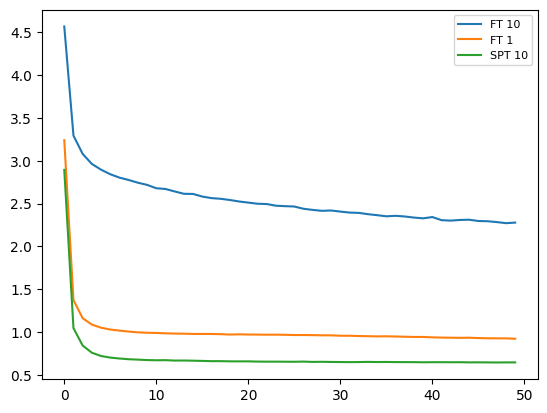

In [17]:
for model, loss in losses.items(): 
    if model in tuning_parameters.keys():
        plt.plot(loss['total'], label=model)
        #plt.plot(loss['sp'], label=model)
        #plt.plot(loss['pp'], label=model)
        #plt.plot(loss['prediction'], label=model)
plt.legend(fontsize=8)


In [18]:
print(protected_columns)
print(sp_idx)

['race', 'age', 'sex']
[2, 1, 0]


In [19]:
from Models import MarginalizedClassifier
protected_values = [X_tensor[:, 0].mode()[0], X_tensor[:, 1].mean(), X_tensor[:, 2].mode()[0]] # Sex, age, race
models['Marginalize'] = MarginalizedClassifier(model=models['Unconstrained'], protected_idx=sp_idx, protected_values=protected_values)

## Evaluation

In [20]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error
from utils import compute_gradient

def evaluate_model(model, X, y, grads):
    preds = model.predict(X)
    proba_preds = model.predict_proba(X)
    gradients = compute_gradient(model, X)
    
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    auc = roc_auc_score(y, proba_preds)
    spd_loss = mean_absolute_error(torch.zeros_like(gradients[:, sp_idx]), gradients[:, sp_idx])
    ppd_loss = mean_absolute_error(grads[:, pp_idx], gradients[:, pp_idx])
    
    return acc, f1, auc, spd_loss, ppd_loss



In [21]:
import pandas as pd
from utils import compute_gradient

# Set number of digits for rounding
n_digits = 2

# Sort models
#model_order = ['Unconstrained', 'FT 10', 'FT 1', 'SPT 10', 'Marginalize']
model_order = models.keys()

# LaTeX table header
latex_table = """
\\begin{table}[h]
\\caption{-}
\\label{tab:compas_prediction}
\\centering
\\begin{tabular}{lrrrrr}
"""
latex_table += f"{'Model':<15} & {'Accuracy':<9} & {'F1 Score':<9} & {'AUC':<4} & {'SPD Loss':<9} & {'PPD Loss':<9} \\\\ \n\\hline\n"

# Iterate through models
for i, model in enumerate(model_order):
    acc, f1, auc, spd_loss, ppd_loss = evaluate_model(models[model], X_tensor, y, unconstrained_gradients)

    latex_table += f"{model:<15} & {acc:<9.{n_digits}f} & {f1:<9.{n_digits}f} & {auc:<4.{n_digits}f} & {spd_loss:<9.{n_digits}f} & {ppd_loss:<9.{n_digits}f}"
    if i < len(models) - 1:
        latex_table += " \\\\ \n"

# Close LaTeX table
latex_table += """
\\end{tabular}
\\end{table}
"""

# Print LaTeX table
print(latex_table)



\begin{table}[h]
\caption{-}
\label{tab:compas_prediction}
\centering
\begin{tabular}{lrrrrr}
Model           & Accuracy  & F1 Score  & AUC  & SPD Loss  & PPD Loss  \\ 
\hline
Unconstrained   & 0.69      & 0.65      & 0.75 & 0.80      & 0.00      \\ 
FT 10           & 0.65      & 0.59      & 0.67 & 0.07      & 0.09      \\ 
FT 1            & 0.64      & 0.57      & 0.68 & 0.00      & 0.26      \\ 
SPT 10          & 0.64      & 0.57      & 0.69 & 0.00      & 0.41      \\ 
Marginalize     & 0.64      & 0.60      & 0.68 & 0.00      & 0.55     
\end{tabular}
\end{table}



### Evaluate fairness

In [22]:
from utils import compute_gradient

# Compute the gradients for the test set
gradients = {}
for label, model in models.items():
    gradients[label] = compute_gradient(model, X_tensor)

Gradient df for plotting

In [23]:
# Make a list of DataFrames for each model using list comprehension
gradients_df = pd.concat([pd.DataFrame(gradients[model], columns=X.columns).assign(Model=model) for model in gradients.keys()])
# Melt the DataFrame
gradients_df = gradients_df.melt(id_vars='Model', var_name='Feature', value_name='Gradient')
# Clean up the feature names
gradients_df['Feature'] = gradients_df['Feature'].str.replace('_', ' ').str.title()
# Make the first letter uppercase
gradients_df['Feature'] = gradients_df['Feature'].str.title()
# Rename Priors Count to Priors and C Charge Degree to Degree
gradients_df['Feature'] = gradients_df['Feature'].str.replace('Priors Count', 'Priors').str.replace('C Charge Degree', 'Degree')
# Make Model a categorical variable
gradients_df['Model'] = pd.Categorical(gradients_df['Model'], categories=model_order, ordered=True)

Colors and markers

In [24]:
from matplotlib.colors import to_rgb, to_rgba

# Base colors
base_color_ft = 'tab:green'
base_color_spd = 'tab:orange'
base_color_manhattan = 'tab:brown'

# Function to adjust lightness
def adjust_lightness(color, factor=0.5):
    rgb = to_rgb(color)
    return [(1 - factor) + factor * c for c in rgb]

# Create lighter/darker shades
palette = {
    'Unconstrained': 'tab:red',
    'Unc.': 'tab:red',
    'SPT 10': adjust_lightness(base_color_spd, 1),
    'FT 1': adjust_lightness(base_color_ft, 0.5),
    'FT 10': adjust_lightness(base_color_ft, 1),
    'Marginalize': 'tab:gray',
    'Marg.': 'tab:gray',
    'FT Manhattan': adjust_lightness(base_color_manhattan, 1),
}

In [25]:
# Formatting
markersize = 8
linewidth = 2
title_font_size = 26
font_size = 24


Box plot

/tmp/ipykernel_17523/1923277162.py:20: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  gradients_df['Model'] = gradients_df['Model'].replace({'Unconstrained': 'Unc.', 'Marginalize': 'Marg.'})


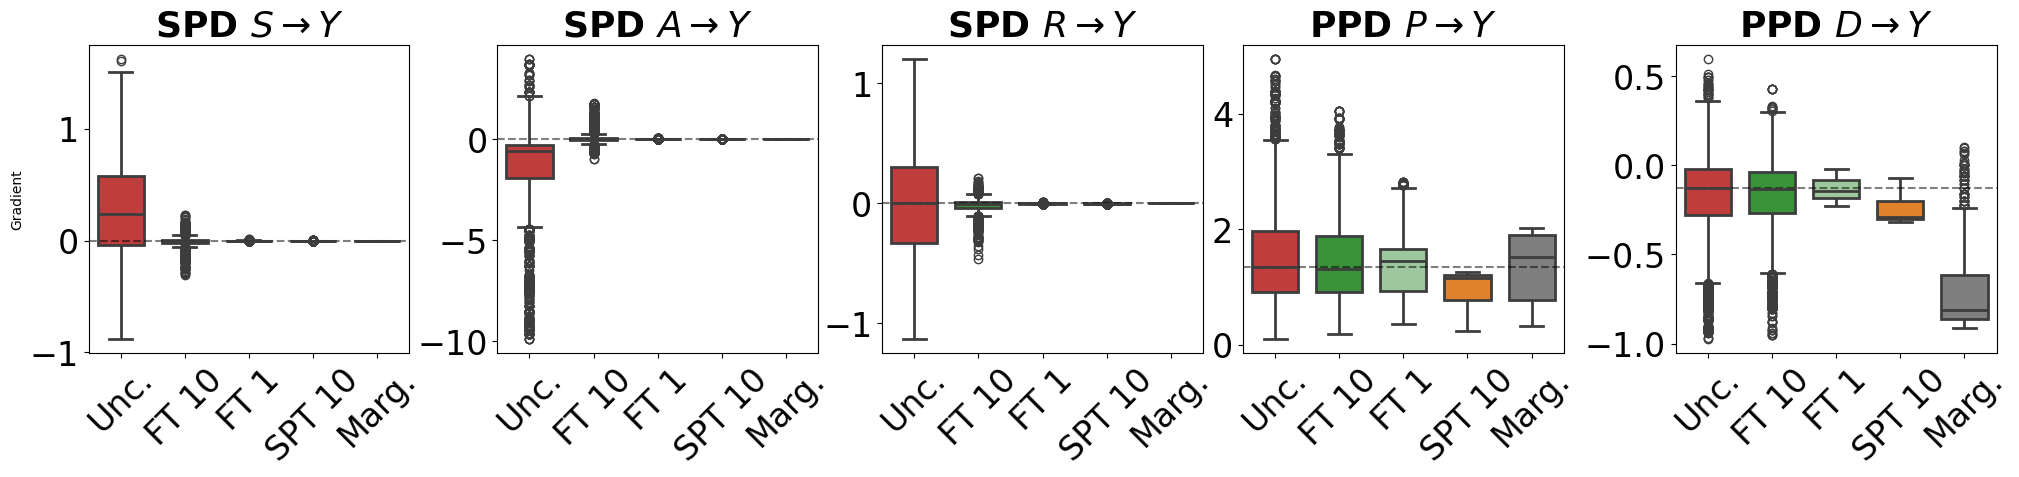

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Number of subplots
num_subplots = len(gradients_df['Feature'].unique())
fig, axes = plt.subplots(1, num_subplots, figsize=(24, 4))
#fig.subplots_adjust(wspace=0.3)  # Increases width space between subplots

# Feature specific formatting
features = gradients_df['Feature'].unique()
titles = {
    'Sex': r'SPD $S \to Y$',
    'Age': r'SPD $A \to Y$',
    'Race': r'SPD $R \to Y$',
    'Degree': r'PPD $D \to Y$',
    'Priors': r'PPD $P \to Y$'
}

# Relabel Unconstrained Unc. and Marginalize Marg.
gradients_df['Model'] = gradients_df['Model'].replace({'Unconstrained': 'Unc.', 'Marginalize': 'Marg.'})

# Store legend handles
handles, labels = None, None
for i, (feature, ax) in enumerate(zip(features, axes)):
    df = gradients_df[gradients_df['Feature'] == feature]
    sns.boxplot(
        data=df,
        x='Model', 
        y='Gradient', 
        hue='Model', 
        palette=palette,
        linewidth=linewidth,
        dodge=False,
        width=0.8,
        gap=0.1,
        ax=ax,
        showfliers=True,
        boxprops=dict(alpha=1), 
    )  

    # x axis
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45, labelsize=font_size)

    # y axis
    min_y = df['Gradient'].min()
    max_y = df['Gradient'].max()
    if i < 3:
        hline_y = 0
    else:
        # Set y ticks to median of Gradient column in df subset where model is Unconstrained
        hline_y = df[df['Model'] == 'Unc.']['Gradient'].median()
    # Set ticks
    ticks = [
        hline_y,
        min_y,
        max_y
    ]

    if i > 0:
        # Remove y-axis label
        ax.set_ylabel('')

    # Set font size for ticks
    ax.tick_params(axis='both', which='major', labelsize=font_size)

    # Horizontal line at 0 or median of Unconstrained models gradient
    ax.axhline(hline_y, color='black', linestyle='--', alpha=0.5)
    
    # Title
    ax.set_title(titles[feature], fontsize=title_font_size, fontweight='bold')


# Increase whitespace between plots
shifts = [0.0, 0.01, 0.01, 0.0, 0.02]
for i, ax in enumerate(axes.flatten()):
    box = ax.get_position()
    ax.set_position([box.x0 + shifts[i], box.y0, box.width, box.height])

plt.show()
fig.savefig('./simulation_results/figures/COMPAS-gradients-box.pdf', bbox_inches='tight')
fig.savefig('./simulation_results/figures/COMPAS-gradients-box.png', bbox_inches='tight')


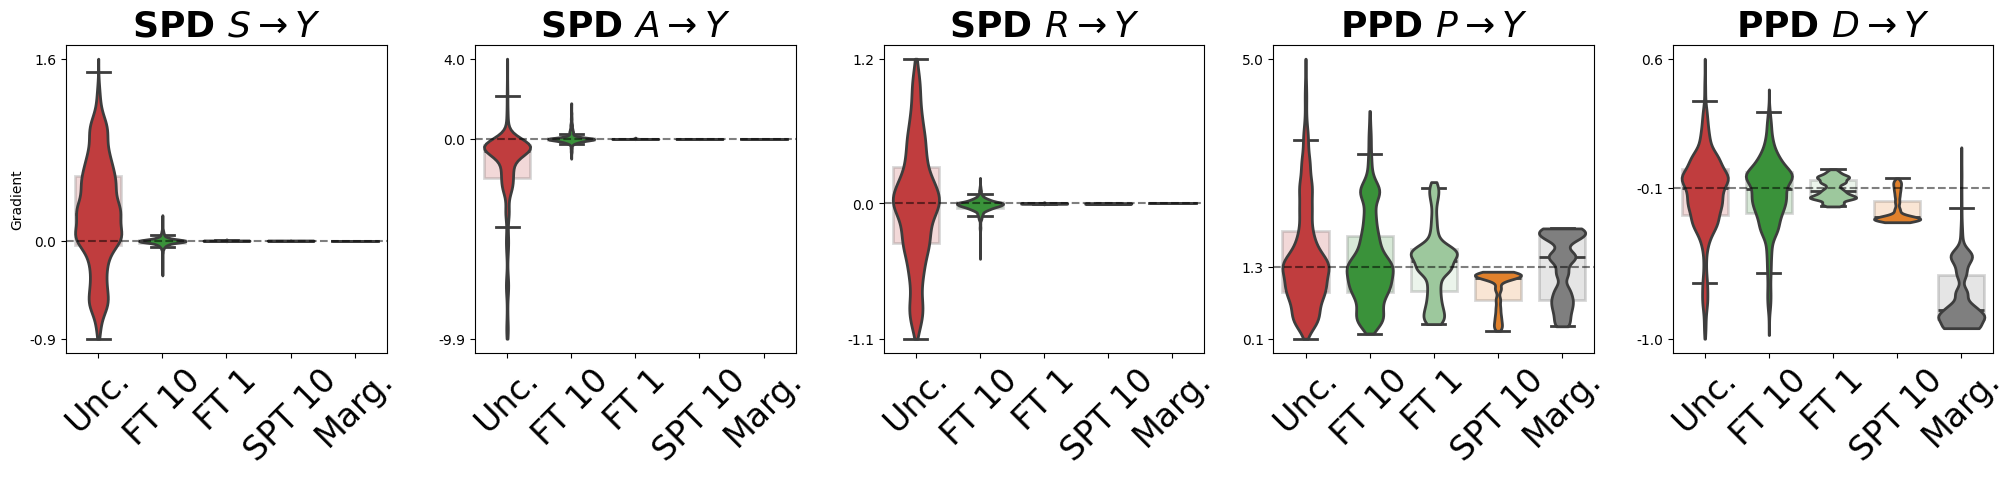

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Number of subplots
num_subplots = len(gradients_df['Feature'].unique())
fig, axes = plt.subplots(1, num_subplots, figsize=(24, 4))

# Feature specific formatting
features = gradients_df['Feature'].unique()
titles = {
    'Sex': r'SPD $S \to Y$',
    'Age': r'SPD $A \to Y$',
    'Race': r'SPD $R \to Y$',
    'Degree': r'PPD $D \to Y$',
    'Priors': r'PPD $P \to Y$'
}

# Store legend handles
handles, labels = None, None
for i, (feature, ax) in enumerate(zip(features, axes)):
    df = gradients_df[gradients_df['Feature'] == feature]
    sns.violinplot(
        data=df, 
        x='Model', 
        y='Gradient', 
        hue='Model', 
        palette=palette,
        linewidth=linewidth,
        dodge=False,
        width=0.8,
        gap=0.1,
        split=False,
        inner=None,
        alpha=1,
        cut=0,
        ax=ax,
        density_norm='count',
        zorder=2
    )  


    sns.boxplot(
        data=df,
        x='Model', 
        y='Gradient', 
        hue='Model', 
        palette=palette,
        linewidth=linewidth,
        dodge=False,
        width=0.8,
        gap=0.1,
        ax=ax,
        showfliers=False,
        boxprops=dict(alpha=0.2), 
        zorder=1,
        legend=False
    )  

    # x axis
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45, labelsize=font_size)

    # y axis
    if i < 3:
        hline_y = 0
    else:
        # Set y ticks to median of Gradient column in df subset where model is Unconstrained
        hline_y = df[df['Model'] == 'Unc.']['Gradient'].median()
    min_y = df['Gradient'].min()
    max_y = df['Gradient'].max()
    #unconstrained_median = df[df['Model'] == 'Unconstrained']['Gradient'].median()
    ticks = [
        hline_y,
        min_y,
        max_y
    ]
    ax.set_yticks(ticks)
    ax.set_yticklabels(np.round(ticks, 1))
    if i > 0:
        # Remove y-axis label
        ax.set_ylabel('')

    # Horizontal line at 0 or median of Unconstrained models gradient
    ax.axhline(hline_y, color='black', linestyle='--', alpha=0.5)
    
    # Title
    ax.set_title(titles[feature], fontsize=title_font_size, fontweight='bold')

# Increase whitespace between plots
shifts = [0.0, 0.01, 0.02, 0.022, 0.028]
for i, ax in enumerate(axes.flatten()):
    box = ax.get_position()
    ax.set_position([box.x0 + shifts[i], box.y0, box.width, box.height])

plt.show()
fig.savefig('./simulation_results/figures/COMPAS-gradients-violin.pdf', bbox_inches='tight')


## Evaluate CTFs

In [28]:
print(protected_columns)
print(sp_idx)
print(pp_idx)

['race', 'age', 'sex']
[2, 1, 0]
[3, 4]


In [29]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error
from utils import compute_gradient

def evaluate_model(model, reference_model, X, y, sp_idx, pp_idx, categorical_idx, combine_spd_and_ppd=True):
    # Performance metrics
    preds = model.predict(X)
    proba_preds = model.predict_proba(X)
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    auc = roc_auc_score(y, proba_preds)

    # Fairness metrics
    # Gradients
    gradients = compute_gradient(model, X)
    reference_gradients = compute_gradient(reference_model, X)

    # Contrasts
    for idx in range(X.shape[1]):
        if idx in categorical_idx:
            X0, X1 = X.clone(), X.clone()
            X0[:, idx], X1[:, idx] = 0, 1
            contrast = model(X1).detach() - model(X0).detach()
            gradients[:, idx] = contrast.squeeze()
            reference_contrast = reference_model(X1).detach() - reference_model(X0).detach()
            reference_gradients[:, idx] = reference_contrast.squeeze()
    
    # Get the intersection of sp_idx and categorical_idx
    sp_categorical = list(set(sp_idx) & set(categorical_idx))
    pp_categorical = list(set(pp_idx) & set(categorical_idx))
    # Get the difference of sp_idx and categorical_idx
    sp_numerical = list(set(sp_idx) - set(sp_categorical))
    pp_numerical = list(set(pp_idx) - set(pp_categorical))

    # Compute the SPD and PPD losses
    spd_loss_categorical = mean_absolute_error(torch.zeros_like(gradients[:, sp_categorical]), gradients[:, sp_categorical])
    spd_loss_numerical = mean_absolute_error(torch.zeros_like(gradients[:, sp_numerical]), gradients[:, sp_numerical])
    ppd_loss_categorical = mean_absolute_error(reference_gradients[:, pp_categorical], gradients[:, pp_categorical])
    ppd_loss_numerical = mean_absolute_error(reference_gradients[:, pp_numerical], gradients[:, pp_numerical])
    # Combine the losses if specified
    if combine_spd_and_ppd:
        spd_loss = (spd_loss_categorical + spd_loss_numerical) / 2
        ppd_loss = (ppd_loss_categorical + ppd_loss_numerical) / 2
        return acc, f1, auc, spd_loss, ppd_loss
    else:
        return acc, f1, auc, spd_loss_categorical, spd_loss_numerical, ppd_loss_categorical, ppd_loss_numerical



In [30]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error
from utils import compute_gradient

def evaluate_model(model, reference_model, X, y, sp_idx, pp_idx, categorical_idx):
    # Performance metrics
    preds = model.predict(X)
    proba_preds = model.predict_proba(X)
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    auc = roc_auc_score(y, proba_preds)

    # Fairness metrics
    # Gradients
    gradients = compute_gradient(model, X)
    reference_gradients = compute_gradient(reference_model, X)

    spd_loss_grad = mean_absolute_error(torch.zeros_like(gradients[:, sp_idx]), gradients[:, sp_idx])
    ppd_loss_grad = mean_absolute_error(reference_gradients[:, pp_idx], gradients[:, pp_idx])

    # Contrasts
    for idx in range(X.shape[1]):
        if idx in categorical_idx:
            X0, X1 = X.clone(), X.clone()
            X1[:, idx] = 1 - X0[:, idx]
            #X0[:, idx], X1[:, idx] = 0, 1
            contrast = model(X1).detach() - model(X0).detach()
            gradients[:, idx] = contrast.squeeze()
            reference_contrast = reference_model(X1).detach() - reference_model(X0).detach()
            reference_gradients[:, idx] = reference_contrast.squeeze()
    
    # Get the intersection of sp_idx and categorical_idx
    spd_loss_contrast = mean_absolute_error(torch.zeros_like(gradients[:, sp_idx]), gradients[:, sp_idx])
    ppd_loss_contrast = mean_absolute_error(reference_gradients[:, pp_idx], gradients[:, pp_idx])

    # Compute the SPD and PPD losses
    return acc, f1, auc, spd_loss_grad, spd_loss_contrast, ppd_loss_grad, ppd_loss_contrast



In [31]:
import pandas as pd
from utils import compute_gradient

# Set number of digits for rounding
n_digits = 2

# Sort models
#model_order = ['Unconstrained', 'FT 10', 'FT 1', 'SPT 10', 'Marginalize']
model_order = models.keys()

# LaTeX table header
latex_table = """
\\begin{table}[h]
\\caption{-}
\\label{tab:compas_prediction}
\\centering
\\begin{tabular}{lrrrrr}
"""
latex_table += f"{'Model':<15} & {'Accuracy':<9} & {'F1 Score':<9} & {'AUC':<4} & {'SPD Loss Grd':<13} & {'SPD Loss Con':<13} & {'PPD Loss Grd':<13} & {'PPD Loss Con':<13} \\\\ \n\\hline\n"

# Iterate through models
categorical_idx = [0, 2, 4] # Sex, Race, Degree
for i, model in enumerate(model_order):
    #acc, f1, auc, spd_loss, ppd_loss = evaluate_model(models[model], models['Unconstrained'], X_tensor, y, sp_idx, pp_idx, categorical_idx)
    acc, f1, auc, spd_loss_cat, spd_loss_num, ppd_loss_cat, ppd_loss_num = evaluate_model(models[model], models['Unconstrained'], X_tensor, y, sp_idx, pp_idx, categorical_idx)


    latex_table += f"{model:<15} & {acc:<9.{n_digits}f} & {f1:<9.{n_digits}f} & {auc:<4.{n_digits}f} & {spd_loss_cat:<14.{n_digits}f} & {spd_loss_num:<13.{n_digits}f} & {ppd_loss_cat:<13.{n_digits}f} & {ppd_loss_num:<13.{n_digits}f}"
    if i < len(models) - 1:
        latex_table += " \\\\ \n"

# Close LaTeX table
latex_table += """
\\end{tabular}
\\end{table}
"""

# Print LaTeX table
print(latex_table)



\begin{table}[h]
\caption{-}
\label{tab:compas_prediction}
\centering
\begin{tabular}{lrrrrr}
Model           & Accuracy  & F1 Score  & AUC  & SPD Loss Grd  & SPD Loss Con  & PPD Loss Grd  & PPD Loss Con  \\ 
\hline
Unconstrained   & 0.69      & 0.65      & 0.75 & 0.80           & 0.79          & 0.00          & 0.00          \\ 
FT 10           & 0.65      & 0.59      & 0.67 & 0.07           & 0.14          & 0.09          & 0.12          \\ 
FT 1            & 0.64      & 0.57      & 0.68 & 0.00           & 0.00          & 0.26          & 0.26          \\ 
SPT 10          & 0.64      & 0.57      & 0.69 & 0.00           & 0.00          & 0.41          & 0.41          \\ 
Marginalize     & 0.64      & 0.60      & 0.68 & 0.00           & 0.00          & 0.55          & 0.60         
\end{tabular}
\end{table}



In [32]:
print(compas.columns)
categorical_variables = ['Sex', 'Race', 'Degree']
categorical_idx = [0, 2, 4] # Sex, Race, Degree

Index(['sex', 'age', 'race', 'priors_count', 'c_charge_degree',
       'two_year_recid'],
      dtype='object')


In [33]:
contrasts_df = []
for feature, idx in zip(categorical_variables, categorical_idx):
    X0, X1 = X_tensor.clone(), X_tensor.clone()
    X0[:, idx], X1[:, idx] = 0, 1
    for model_name, model in models.items():
        contrast = model.predict_proba(X1) - model.predict_proba(X0)
        df = pd.DataFrame({
            'Contrast': contrast,
            'Sample': np.arange(len(contrast)),
            'Feature': feature,
            'Model': model_name
        })
        contrasts_df.append(df)

contrasts_df = pd.concat(contrasts_df, ignore_index=True)

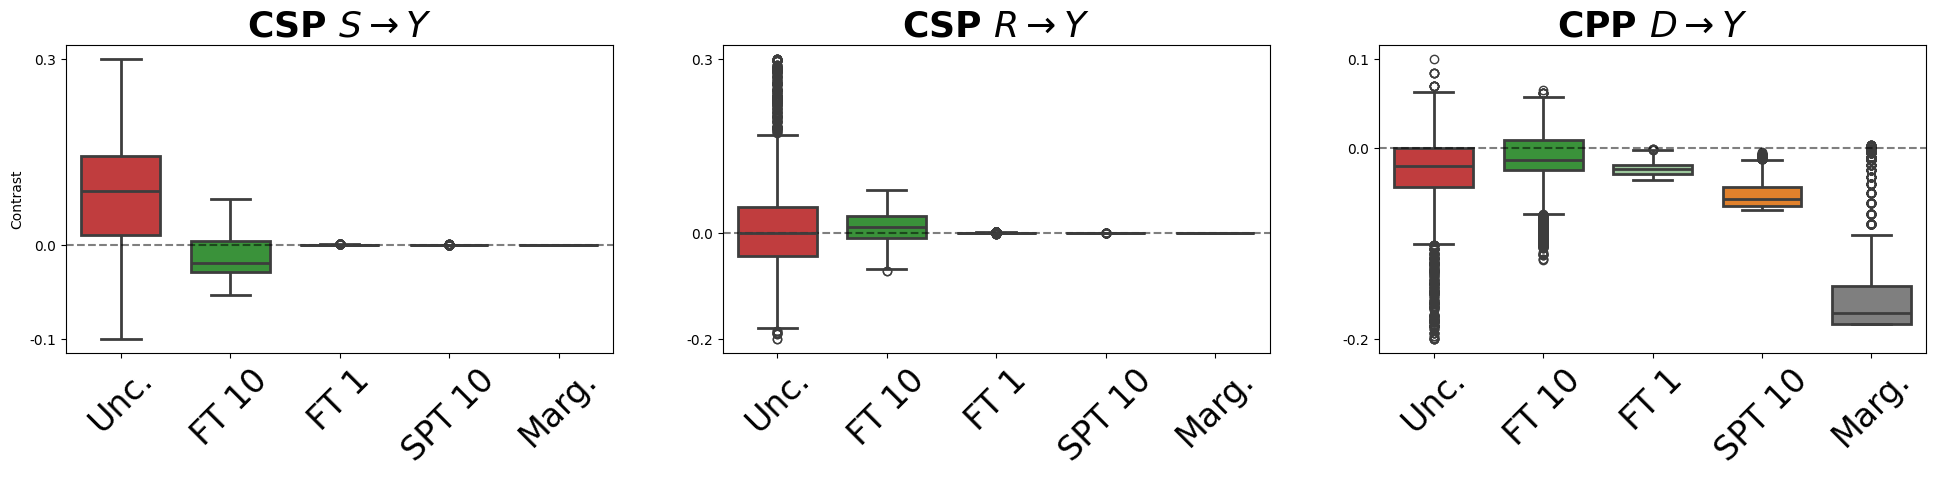

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Number of subplots
num_subplots = len(contrasts_df['Feature'].unique())
fig, axes = plt.subplots(1, num_subplots, figsize=(24, 4))
#fig.subplots_adjust(wspace=0.3)  # Increases width space between subplots

# Feature specific formatting
features = contrasts_df['Feature'].unique()
titles = {
    'Sex': r'CSP $S \to Y$',
    'Race': r'CSP $R \to Y$',
    'Degree': r'CPP $D \to Y$',
}

# Relabel Unconstrained Unc. and Marginalize Marg.
contrasts_df['Model'] = contrasts_df['Model'].replace({'Unconstrained': 'Unc.', 'Marginalize': 'Marg.'})

# Store legend handles
handles, labels = None, None
for i, (feature, ax) in enumerate(zip(features, axes)):
    df = contrasts_df[contrasts_df['Feature'] == feature]
    sns.boxplot(
        data=df,
        x='Model', 
        y='Contrast', 
        hue='Model', 
        palette=palette,
        linewidth=linewidth,
        dodge=False,
        width=0.8,
        gap=0.1,
        ax=ax,
        showfliers=True,
        boxprops=dict(alpha=1), 
    )  

    # x axis
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45, labelsize=font_size)

    # y axis
    if i < 3:
        hline_y = 0
    else:
        # Set y ticks to median of Gradient column in df subset where model is Unconstrained
        hline_y = df[df['Model'] == 'Unconstrained']['Contrast'].median()
    min_y = df['Contrast'].min()
    max_y = df['Contrast'].max()
    #unconstrained_median = df[df['Model'] == 'Unconstrained']['Gradient'].median()
    ticks = [
        hline_y,
        min_y,
        max_y
    ]
    ax.set_yticks(ticks)
    ax.set_yticklabels(np.round(ticks, 1))
    if i > 0:
        # Remove y-axis label
        ax.set_ylabel('')

    # Horizontal line at 0 or median of Unconstrained models gradient
    ax.axhline(hline_y, color='black', linestyle='--', alpha=0.5)
    
    # Title
    ax.set_title(titles[feature], fontsize=title_font_size, fontweight='bold')

plt.show()
fig.savefig('./simulation_results/figures/COMPAS-contrasts-box.pdf', bbox_inches='tight')
